# Advanced Regression Pipeline: CatBoost, XGBoost, and Random Forest Comparison

This notebook builds on the LightGBM pipeline to compare three regression algorithms (CatBoost, XGBoost, Random Forest) using data from the local database. It includes data loading, preprocessing, model training, evaluation, and visualization.

## 1. Import Required Libraries and Environment Setup
Import all necessary libraries, set up environment variables, and check GPU availability for LightGBM, CatBoost, and XGBoost.

In [1]:
# Import libraries
import os
from dotenv import load_dotenv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from pytorch_tabnet.tab_model import TabNetRegressor

# Load environment variables from .env file
load_dotenv(override=True)

# Database connection parameters
db_params = {
    "host": os.getenv("LOCAL_HOST"),
    "user": os.getenv("LOCAL_USER"),
    "password": os.getenv("LOCAL_PW"),
    "port": os.getenv("LOCAL_PORT"),
    "dbname": os.getenv("LOCAL_DB")
}

# Display versions
print('LightGBM version:', lgb.__version__)
print('CatBoost version:', __import__('catboost').__version__)
print('XGBoost version:', xgb.__version__)
print('Pandas version:', pd.__version__)

LightGBM version: 4.6.0
CatBoost version: 1.2.8
XGBoost version: 3.0.5
Pandas version: 2.1.4


## 2. Load Data from Database
Connect to the database, execute SQL to load the golden table, and prepare the DataFrame for modeling.

In [2]:
# Connect to database and load data
try:
    conn = psycopg2.connect(**db_params)
    print("Database connection successful")
    sql_query = "SELECT * FROM dev.golden_table;"
    df = pd.read_sql_query(sql_query, conn)
    conn.close()
    print("Golden data loaded into DataFrame:")
    print(df.info())
except Exception as e:
    print(f"An error occurred: {e}")

Database connection successful


C:\Users\Leo\AppData\Local\Temp\ipykernel_21108\3569683717.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, conn)


Golden data loaded into DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23038 entries, 0 to 23037
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   school_name             23038 non-null  object 
 1   school_type             23038 non-null  object 
 2   teachers_fte            22550 non-null  float64
 3   enrollment              22863 non-null  float64
 4   grade_eight_enrollment  21613 non-null  float64
 5   math_counts             22507 non-null  float64
 6   math_high_pct           22507 non-null  float64
 7   math_low_pct            19960 non-null  float64
 8   read_counts             22386 non-null  float64
 9   read_high_pct           22386 non-null  float64
 10  read_low_pct            19907 non-null  float64
 11  pct_hhi_150k_200k       23038 non-null  float64
 12  pct_hhi_220k_plus       23038 non-null  float64
 13  avg_natwalkind          23038 non-null  float64
 14  tot

## 3. Data Splitting: Train, Validation, Test
Split the dataset into train, validation, and test sets, ensuring proper handling of the target variable.

In [ ]:
# Define target and drop missing
TARGET = 'math_high_pct' if 'math_high_pct' in df.columns else 'target'
data = df.dropna().reset_index(drop=True)
drop_cols = ['hhi_150k_200k', 'hhi_220k_plus','total_10_14']
data = data.drop(columns=drop_cols)
data = data.set_index('school_name')

# Split features and target
feature_cols = [c for c in data.columns if c != TARGET and c != 'dup_rank']
X = data[feature_cols]
y = data[TARGET]

# Train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
print(f'Train shape: {X_train.shape}, Validation shape: {X_valid.shape}, Test shape: {X_test.shape}')

Train shape: (11367, 19), Validation shape: (3789, 19), Test shape: (3789, 19)


## 4. Feature Engineering and Preprocessing Pipeline
Identify numeric and categorical features, set up StandardScaler and OneHotEncoder, and build a ColumnTransformer pipeline.

In [24]:
# Identify numeric and categorical features
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Fit preprocessor
preprocessor.fit(X_train)
X_train_enc = preprocessor.transform(X_train)
X_valid_enc = preprocessor.transform(X_valid)
X_test_enc = preprocessor.transform(X_test)

Numeric features: ['teachers_fte', 'enrollment', 'grade_eight_enrollment', 'math_counts', 'math_low_pct', 'read_counts', 'read_high_pct', 'read_low_pct', 'pct_hhi_150k_200k', 'pct_hhi_220k_plus', 'avg_natwalkind', 'total_10_14', 'pct_10_14', 'pct_female_10_14', 'total_pop', 'hhi_150k_200k', 'hhi_220k_plus', 'schools_in_zip']
Categorical features: ['school_type']


## 5. Tree-based ensemble models - XGBoost, and Random Forest Regressors

Configure, train, and evaluate all three models using the preprocessed data.

### 5.1 Hyperparameter Optimization Utility

In [25]:
# Reusable Optuna-based optimizer for cross-validated hyperparameter tuning
from typing import Callable, Dict, Tuple


def optimize_model_with_optuna(
    model_name: str,
    estimator_builder: Callable[[Dict], object],
    param_space_fn: Callable[[optuna.trial.Trial], Dict],
    X,
    y,
    scoring: str = 'neg_root_mean_squared_error',
    cv: int = 3,
    n_trials: int = 25,
    direction: str = 'minimize',
    random_state: int = 42,
    n_jobs: int = -1,
) -> Tuple[optuna.study.Study, Dict]:
    """Optimize a model's hyperparameters using Optuna and cross-validation.

    Args:
        model_name: Name used to label the Optuna study.
        estimator_builder: Callable that receives a params dict and returns an unfitted estimator.
        param_space_fn: Callable that maps an Optuna trial to a hyperparameter dictionary.
        X, y: Training features and targets used for cross-validation.
        scoring: scikit-learn scoring string guiding optimization.
        cv: Number of cross-validation folds.
        n_trials: Number of Optuna trials to run.
        direction: 'minimize' or 'maximize' depending on the objective.
        random_state: Seed for the Optuna sampler.
        n_jobs: Parallelism for cross_val_score.

    Returns:
        The completed Optuna study and the best hyperparameters discovered.
    """
    sampler = optuna.samplers.TPESampler(seed=random_state)
    study = optuna.create_study(study_name=f"{model_name}_opt", direction=direction, sampler=sampler)

    def objective(trial: optuna.trial.Trial) -> float:
        params = param_space_fn(trial)
        estimator = estimator_builder(params)
        scores = cross_val_score(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs)
        mean_score = np.mean(scores)
        normalized_score = -mean_score if scoring.startswith('neg') else mean_score
        return normalized_score if direction == 'minimize' else -normalized_score

    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    return study, study.best_params

In [26]:
# Hyperparameter optimization and training for ensemble models

def build_xgb_estimator(params: Dict) -> XGBRegressor:
    base_params = {
        'random_state': 42,
        'device': 'cuda',
        'verbosity': 0,
        'tree_method': 'gpu_hist'
    }
    base_params.update(params)
    return XGBRegressor(**base_params)


def xgb_param_space(trial: optuna.trial.Trial) -> Dict:
    return {
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1e-1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1e-1, log=True)
    }


def build_rf_estimator(params: Dict) -> RandomForestRegressor:
    base_params = {
        'random_state': 42,
        'n_jobs': -1
    }
    base_params.update(params)
    return RandomForestRegressor(**base_params)


def rf_param_space(trial: optuna.trial.Trial) -> Dict:
    return {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'max_depth': trial.suggest_int('max_depth', 5, 25),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_float('max_features', 0.4, 1.0)
    }


xgb_study, xgb_best_params = optimize_model_with_optuna(
    model_name='XGBoost',
    estimator_builder=build_xgb_estimator,
    param_space_fn=xgb_param_space,
    X=X_train_enc,
    y=y_train,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_trials=25,
    direction='minimize',
    random_state=42,
    n_jobs=-1
)
print('Best XGBoost params:', xgb_best_params)

rf_study, rf_best_params = optimize_model_with_optuna(
    model_name='RandomForest',
    estimator_builder=build_rf_estimator,
    param_space_fn=rf_param_space,
    X=X_train_enc,
    y=y_train,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_trials=25,
    direction='minimize',
    random_state=42,
    n_jobs=-1
)
print('Best Random Forest params:', rf_best_params)

# Fit models with optimized hyperparameters
xgb_model = build_xgb_estimator(xgb_best_params)
xgb_model.fit(X_train_enc, y_train)
xgb_valid_pred = xgb_model.predict(X_valid_enc)
xgb_test_pred = xgb_model.predict(X_test_enc)

rf_model = build_rf_estimator(rf_best_params)
rf_model.fit(X_train_enc, y_train)
rf_valid_pred = rf_model.predict(X_valid_enc)
rf_test_pred = rf_model.predict(X_test_enc)

[I 2025-10-04 17:05:02,531] A new study created in memory with name: XGBoost_opt
[I 2025-10-04 17:05:17,081] Trial 0 finished with value: 11.023996548332809 and parameters: {'n_estimators': 350, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 1.23583827723069e-07, 'reg_lambda': 2.5502648504032812e-08}. Best is trial 0 with value: 11.023996548332809.
[I 2025-10-04 17:05:26,568] Trial 1 finished with value: 11.042297182731431 and parameters: {'n_estimators': 547, 'max_depth': 7, 'learning_rate': 0.11114989443094977, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 0.006715811311069936, 'reg_lambda': 3.0645998412411426e-07}. Best is trial 0 with value: 11.023996548332809.
[I 2025-10-04 17:05:28,533] Trial 2 finished with value: 10.618748471676737 and parameters: {'n_estimators': 272, 'max_depth': 4, 'learning_rate': 0.028145092716060652, 'subsample': 0.8099025726

Best XGBoost params: {'n_estimators': 477, 'max_depth': 6, 'learning_rate': 0.019430664347487043, 'subsample': 0.8524698285825317, 'colsample_bytree': 0.7616287146723624, 'reg_alpha': 6.8273138102708e-08, 'reg_lambda': 0.0036650870725902364}


[I 2025-10-04 17:07:33,241] Trial 0 finished with value: 10.510100905465201 and parameters: {'n_estimators': 425, 'max_depth': 24, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 0.4936111842654619}. Best is trial 0 with value: 10.510100905465201.
[I 2025-10-04 17:07:37,921] Trial 1 finished with value: 10.691736224274285 and parameters: {'n_estimators': 293, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 0.8248435466776274}. Best is trial 0 with value: 10.510100905465201.
[I 2025-10-04 17:07:37,921] Trial 1 finished with value: 10.691736224274285 and parameters: {'n_estimators': 293, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 0.8248435466776274}. Best is trial 0 with value: 10.510100905465201.
[I 2025-10-04 17:07:42,024] Trial 2 finished with value: 10.462200840140305 and parameters: {'n_estimators': 212, 'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 0.5090949803242604}

Best Random Forest params: {'n_estimators': 454, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 0.8712420858015641}


## 6. Compare Model Performance
Evaluate predictions from each model using RMSE, MAE, and R² metrics.

In [27]:
# Helper functions for metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def adjusted_r2_score(r2, n, p):
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

def regression_metrics(y_true, y_pred, X=None):
    try:
        # Try using root_mean_squared_error if available (sklearn >= 1.4)
        from sklearn.metrics import root_mean_squared_error
        rmse = root_mean_squared_error(y_true, y_pred)
    except ImportError:
        # Fall back to mean_squared_error with squared=False for older versions
        rmse = mean_squared_error(y_true, y_pred, squared=False)
    
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    metrics = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    if X is not None:
        n = X.shape[0]
        p = X.shape[1]
        adj_r2 = adjusted_r2_score(r2, n, p)
        metrics['Adj_R2'] = adj_r2
    return metrics

# Validation metrics
xgb_metrics = regression_metrics(y_valid, xgb_valid_pred, X_valid_enc)
rf_metrics = regression_metrics(y_valid, rf_valid_pred, X_valid_enc)

# Test metrics
xgb_test_metrics = regression_metrics(y_test, xgb_test_pred, X_test_enc)
rf_test_metrics = regression_metrics(y_test, rf_test_pred, X_test_enc)

# Display results
results_df = pd.DataFrame({
    'XGBoost_Valid': xgb_metrics,
    'RandomForest_Valid': rf_metrics,
    'XGBoost_Test': xgb_test_metrics,
    'RandomForest_Test': rf_test_metrics
})
display(results_df)

,XGBoost_Valid,RandomForest_Valid,XGBoost_Test,RandomForest_Test
RMSE,9.953017,9.889784,10.319262,10.336057
MAE,5.386716,4.931857,5.459281,5.072914
R2,0.804890,0.807361,0.779875,0.779158
Adj_R2,0.803750,0.806236,0.778589,0.777867


### 6.1 Learning Curves for Ensemble Models

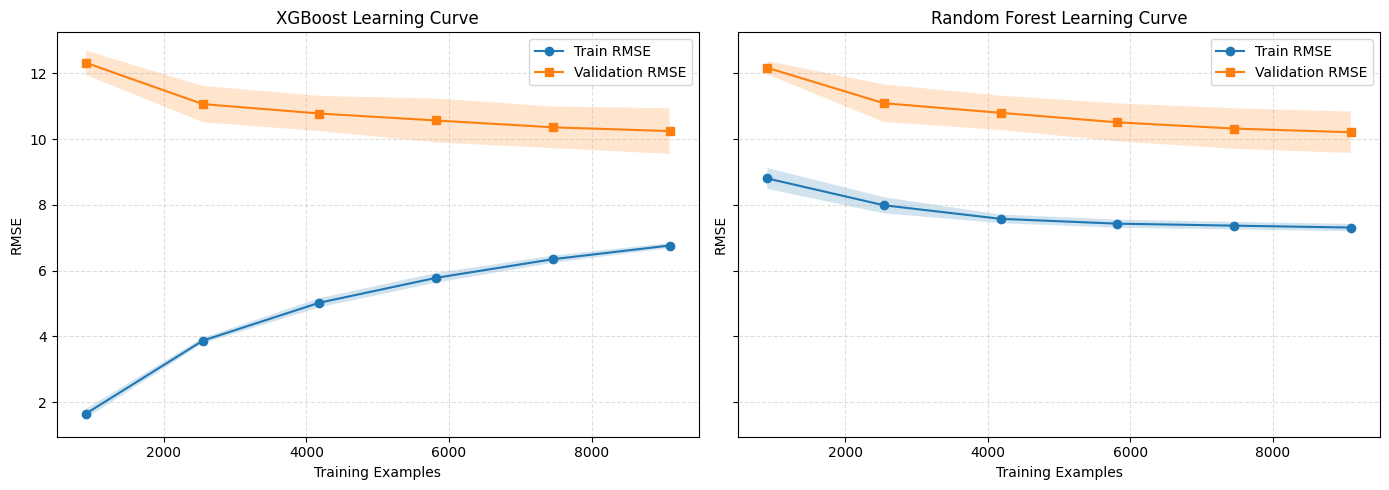

In [28]:
# Learning curves for ensemble models
from sklearn.model_selection import learning_curve
from sklearn.base import clone

def plot_learning_curve(estimator, X, y, ax, title, cv=5, scoring='neg_root_mean_squared_error'):
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 6),
        shuffle=True,
        random_state=42
    )
    train_rmse = -train_scores.mean(axis=1)
    valid_rmse = -valid_scores.mean(axis=1)

    ax.plot(train_sizes, train_rmse, label='Train RMSE', marker='o')
    ax.fill_between(train_sizes, train_rmse - train_scores.std(axis=1), train_rmse + train_scores.std(axis=1), alpha=0.2)
    ax.plot(train_sizes, valid_rmse, label='Validation RMSE', marker='s')
    ax.fill_between(train_sizes, valid_rmse - valid_scores.std(axis=1), valid_rmse + valid_scores.std(axis=1), alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel('Training Examples')
    ax.set_ylabel('RMSE')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.4)

xgb_curve_model = clone(xgb_model)
rf_curve_model = clone(rf_model)


fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
plot_learning_curve(xgb_curve_model, X_train_enc, y_train, axes[0], 'XGBoost Learning Curve')
plot_learning_curve(rf_curve_model, X_train_enc, y_train, axes[1], 'Random Forest Learning Curve')
plt.tight_layout()
plt.show()

## This is the Neural Network NLP model

### 5.2 Estimator Builders & Param Spaces for MLP and TabNet

In [ ]:
# Builders and parameter spaces for MLPRegressor and TabNetRegressor
from sklearn.neural_network import MLPRegressor
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_is_fitted


def build_mlp_estimator(params: Dict) -> MLPRegressor:
    """Return an MLPRegressor with sensible defaults overridden by params.
    Early stopping is enabled to reduce overfitting; verbose disabled for cleaner logs.
    """
    defaults = dict(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        learning_rate_init=0.001,
        max_iter=500,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=15,
        random_state=42,
        verbose=False
    )
    defaults.update(params)
    return MLPRegressor(**defaults)


def mlp_param_space(trial: optuna.trial.Trial) -> Dict:
    return {
        'hidden_layer_sizes': tuple(sorted([
            trial.suggest_int('hl1', 64, 256, step=32),
            trial.suggest_int('hl2', 32, 192, step=32)
        ], reverse=True)),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True),
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256]),
        'max_iter': trial.suggest_int('max_iter', 200, 800, step=100)
    }


def _to_float32_dense(X):
    return X.toarray().astype(np.float32) if hasattr(X, 'toarray') else np.asarray(X, dtype=np.float32)


class TabNetRegressorWrapper(BaseEstimator, RegressorMixin):
    """A scikit-learn compatible wrapper for TabNetRegressor.

    Handles:
      - Converting sparse matrices to dense float32
      - Reshaping 1D y -> 2D (n,1) required by TabNet
      - Providing predict that returns 1D array
    """
    def __init__(self, max_epochs=200, patience=50, batch_size=1024, virtual_batch_size=128, eval_metric='rmse', seed=42, verbose=0, **tabnet_params):
        self.max_epochs = max_epochs
        self.patience = patience
        self.batch_size = batch_size
        self.virtual_batch_size = virtual_batch_size
        self.eval_metric = eval_metric if isinstance(eval_metric, (list, tuple)) else [eval_metric]
        self.seed = seed
        self.verbose = verbose
        self.tabnet_params = tabnet_params
        self.model_ = None

    def _to_dense32(self, X):
        return _to_float32_dense(X)

    def fit(self, X, y):
        Xd = self._to_dense32(X)
        y_arr = np.asarray(y)
        if y_arr.ndim == 1:
            y_arr = y_arr.reshape(-1, 1)
        self.model_ = TabNetRegressor(seed=self.seed, verbose=self.verbose, **self.tabnet_params)
        # Simple split for early stopping (can be improved to use a true validation fold if desired)
        self.model_.fit(
            Xd,
            y_arr,
            eval_set=[(Xd, y_arr)],  # using training data for eval to keep interface simple in CV
            eval_metric=self.eval_metric,
            patience=self.patience,
            max_epochs=self.max_epochs,
            batch_size=self.batch_size,
            virtual_batch_size=self.virtual_batch_size,
        )
        return self

    def predict(self, X):
        check_is_fitted(self, 'model_')
        Xd = self._to_dense32(X)
        preds = self.model_.predict(Xd)
        return preds.ravel()


def build_tabnet_estimator(params: Dict) -> TabNetRegressorWrapper:
    """Return a TabNetRegressorWrapper with defaults merged with tuned params."""
    defaults = dict(
        n_d=16, n_a=16, n_steps=5, gamma=1.3,
        lambda_sparse=1e-4,
        optimizer_params={'lr': 2e-2},
    )
    defaults.update(params)
    # Separate training control params if user tries to tune them (optional)
    training_keys = ['max_epochs', 'patience', 'batch_size', 'virtual_batch_size']
    training_overrides = {k: defaults.pop(k) for k in list(defaults.keys()) if k in training_keys}
    return TabNetRegressorWrapper(**training_overrides, **defaults)


def tabnet_param_space(trial: optuna.trial.Trial) -> Dict:
    return {
        'n_d': trial.suggest_categorical('n_d', [8, 16, 24, 32]),
        'n_a': trial.suggest_categorical('n_a', [8, 16, 24, 32]),
        'n_steps': trial.suggest_int('n_steps', 3, 8),
        'gamma': trial.suggest_float('gamma', 1.0, 2.0),
        'lambda_sparse': trial.suggest_float('lambda_sparse', 1e-6, 1e-3, log=True),
        'optimizer_params': {'lr': trial.suggest_float('lr', 1e-3, 5e-2, log=True)},
        # Optionally allow tuning of training controls:
        'max_epochs': 200,
        'patience': 50,
        'batch_size': 1024,
        'virtual_batch_size': 128,
    }

# Run MLP optimization
mlp_study, mlp_best_params = optimize_model_with_optuna(
    model_name='MLPRegressor',
    estimator_builder=build_mlp_estimator,
    param_space_fn=mlp_param_space,
    X=X_train_enc,
    y=y_train,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_trials=25,
    direction='minimize',
    random_state=42,
    n_jobs=-1,
)
print('Best MLPRegressor params:', mlp_best_params)

# Run TabNet optimization (wrapper handles dense conversion & y reshape)
tabnet_study, tabnet_best_params = optimize_model_with_optuna(
    model_name='TabNetRegressor',
    estimator_builder=build_tabnet_estimator,
    param_space_fn=tabnet_param_space,
    X=X_train_enc,  # pass original (possibly sparse) matrix
    y=y_train,      # pass 1D target
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_trials=25,
    direction='minimize',
    random_state=42,
    n_jobs=-1,
)
print('Best TabNetRegressor params:', tabnet_best_params)

[I 2025-10-04 17:15:17,901] A new study created in memory with name: MLPRegressor_opt
[I 2025-10-04 17:15:26,947] Trial 0 finished with value: 12.223494846208524 and parameters: {'hl1': 128, 'hl2': 192, 'learning_rate_init': 0.0029106359131330704, 'alpha': 0.0002481040974867811, 'batch_size': 64, 'max_iter': 800}. Best is trial 0 with value: 12.223494846208524.
[I 2025-10-04 17:16:13,986] Trial 1 finished with value: 12.524675594540957 and parameters: {'hl1': 192, 'hl2': 160, 'learning_rate_init': 0.00010994335574766199, 'alpha': 0.00757947995334801, 'batch_size': 64, 'max_iter': 300}. Best is trial 0 with value: 12.223494846208524.
[I 2025-10-04 17:16:21,051] Trial 2 finished with value: 12.349596753538194 and parameters: {'hl1': 128, 'hl2': 128, 'learning_rate_init': 0.0007309539835912913, 'alpha': 1.461896279370496e-05, 'batch_size': 64, 'max_iter': 400}. Best is trial 0 with value: 12.223494846208524.
[I 2025-10-04 17:16:38,436] Trial 3 finished with value: 12.647238599635552 and p

Best MLPRegressor params: {'hl1': 192, 'hl2': 96, 'learning_rate_init': 0.006540956231076377, 'alpha': 8.677617597791063e-06, 'batch_size': 64, 'max_iter': 700}


[I 2025-10-04 17:21:08,655] Trial 0 finished with value: 11.145608864161312 and parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 6, 'gamma': 1.7080725777960455, 'lambda_sparse': 1.1527987128232402e-06, 'lr': 0.044447541666908126}. Best is trial 0 with value: 11.145608864161312.
[I 2025-10-04 17:22:58,944] Trial 1 finished with value: 11.145608864161312 and parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 6, 'gamma': 1.139493860652042, 'lambda_sparse': 7.523742884534855e-06, 'lr': 0.004192159350410977}. Best is trial 0 with value: 11.145608864161312.
[I 2025-10-04 17:24:46,617] Trial 2 finished with value: 11.145608864161312 and parameters: {'n_d': 16, 'n_a': 24, 'n_steps': 3, 'gamma': 1.9488855372533331, 'lambda_sparse': 0.0007886714129990489, 'lr': 0.02362886418423641}. Best is trial 0 with value: 11.145608864161312.


In [ ]:
# (Optional) Refit MLP & TabNet with best hyperparameters and evaluate on validation/test
from sklearn.metrics import mean_squared_error

# Rebuild tuned models
if 'mlp_best_params' in globals():
    tuned_mlp = build_mlp_estimator(mlp_best_params)
    tuned_mlp.fit(X_train_enc, y_train)
    tuned_mlp_valid_pred = tuned_mlp.predict(X_valid_enc)
    tuned_mlp_test_pred = tuned_mlp.predict(X_test_enc)
else:
    tuned_mlp = None

if 'tabnet_best_params' in globals():
    tuned_tabnet = build_tabnet_estimator(tabnet_best_params)
    tuned_tabnet.fit(X_train_enc, y_train)
    tuned_tabnet_valid_pred = tuned_tabnet.predict(X_valid_enc)
    tuned_tabnet_test_pred = tuned_tabnet.predict(X_test_enc)
else:
    tuned_tabnet = None

rows = []
if tuned_mlp:
    rows.append({'Model':'MLP (Tuned)','Dataset':'Validation', **regression_metrics(y_valid, tuned_mlp_valid_pred, X_valid_enc)})
    rows.append({'Model':'MLP (Tuned)','Dataset':'Test', **regression_metrics(y_test, tuned_mlp_test_pred, X_test_enc)})
if tuned_tabnet:
    rows.append({'Model':'TabNet (Tuned)','Dataset':'Validation', **regression_metrics(y_valid, tuned_tabnet_valid_pred, X_valid_enc)})
    rows.append({'Model':'TabNet (Tuned)','Dataset':'Test', **regression_metrics(y_test, tuned_tabnet_test_pred, X_test_enc)})

if rows:
    tuned_df = pd.DataFrame(rows).set_index(['Model','Dataset'])
    display(tuned_df)
else:
    print('No tuned models available yet.')

In [ ]:
# Neural Network Regression using MLPRegressor

# Train MLPRegressor (Neural Network)
mlp_model = MLPRegressor(
                        hidden_layer_sizes=(100, 50), 
                        activation='relu', 
                        solver='adam', 
                        max_iter=1000, 
                        random_state=42, 
                        early_stopping=True, 
                        verbose=False
)
mlp_model.fit(X_train_enc, y_train)
mlp_valid_pred = mlp_model.predict(X_valid_enc)
mlp_test_pred = mlp_model.predict(X_test_enc)

# Prepare dense data for TabNet
X_train_tab = _to_float32_dense(X_train_enc)
X_valid_tab = _to_float32_dense(X_valid_enc)
X_test_tab = _to_float32_dense(X_test_enc)
y_train_tab = y_train.values.reshape(-1, 1).astype(np.float32)
y_valid_tab = y_valid.values.reshape(-1, 1).astype(np.float32)
y_test_tab = y_test.values.reshape(-1, 1).astype(np.float32)

# Train TabNetRegressor
tabnet_model = TabNetRegressor(
    n_d=16,
    n_a=16,
    n_steps=5,
    gamma=1.3,
    lambda_sparse=1e-4,
    seed=42,
    verbose=10
)
tabnet_model.fit(
    X_train_tab,
    y_train_tab,
    eval_set=[(X_valid_tab, y_valid_tab)],
    eval_metric=['rmse'],
    patience=50,
    max_epochs=200,
    batch_size=1024,
    virtual_batch_size=128
)

tabnet_valid_pred = tabnet_model.predict(X_valid_tab).ravel()
tabnet_test_pred = tabnet_model.predict(X_test_tab).ravel()

# Evaluate performance
mlp_valid_metrics = regression_metrics(y_valid, mlp_valid_pred, X_valid_enc)
mlp_test_metrics = regression_metrics(y_test, mlp_test_pred, X_test_enc)
tabnet_valid_metrics = regression_metrics(y_valid, tabnet_valid_pred, X_valid_enc)
tabnet_test_metrics = regression_metrics(y_test, tabnet_test_pred, X_test_enc)

comparison_rows = [
    {'Model': 'MLP', 'Dataset': 'Validation', **mlp_valid_metrics},
    {'Model': 'MLP', 'Dataset': 'Test', **mlp_test_metrics},
    {'Model': 'TabNet', 'Dataset': 'Validation', **tabnet_valid_metrics},
    {'Model': 'TabNet', 'Dataset': 'Test', **tabnet_test_metrics},
]
comparison_df = pd.DataFrame(comparison_rows).set_index(['Model', 'Dataset'])
display(comparison_df)

Iteration 1, loss = 1266.32795069
Validation score: -3.097704
Iteration 2, loss = 544.14012836
Validation score: -0.053561
Iteration 3, loss = 186.19642767
Validation score: 0.272557
Iteration 4, loss = 145.75859901
Validation score: 0.363298
Iteration 5, loss = 130.47059309
Validation score: 0.413627
Iteration 6, loss = 120.81212716
Validation score: 0.443935
Iteration 7, loss = 114.32657882
Validation score: 0.466035
Iteration 8, loss = 109.02835826
Validation score: 0.484692
Iteration 9, loss = 104.52068994
Validation score: 0.498565
Iteration 10, loss = 100.84882883
Validation score: 0.509542
Iteration 11, loss = 97.61103605
Validation score: 0.524590
Iteration 12, loss = 94.53159067
Validation score: 0.535825
Iteration 13, loss = 91.99462183
Validation score: 0.548618
Iteration 14, loss = 89.72142293
Validation score: 0.559750
Iteration 15, loss = 88.17317434
Validation score: 0.570218
Iteration 16, loss = 86.51340813
Validation score: 0.577868
Iteration 17, loss = 85.14911482
Val

## 7. Hyperparameter Tuning with Optuna
Use Optuna to optimize hyperparameters for CatBoost, XGBoost, and Random Forest regressors.

In [ ]:
# Optuna tuning for CatBoost, XGBoost, and Random Forest

# CatBoost tuning
# XGBoost tuning
def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'verbosity': 0
    }
    model = XGBRegressor(**params)
    scores = cross_val_score(model, X_train_enc, y_train, cv=3, scoring='neg_root_mean_squared_error')
    return -scores.mean()

xgb_study = optuna.create_study(direction='minimize')
xgb_study.optimize(xgb_objective, n_trials=20)
print('Best XGBoost params:', xgb_study.best_params)

# Random Forest tuning
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'random_state': 42
    }
    model = RandomForestRegressor(**params)
    scores = cross_val_score(model, X_train_enc, y_train, cv=3, scoring='neg_root_mean_squared_error')
    return -scores.mean()

rf_study = optuna.create_study(direction='minimize')
rf_study.optimize(rf_objective, n_trials=20)
print('Best Random Forest params:', rf_study.best_params)

[I 2025-10-04 11:56:30,731] A new study created in memory with name: no-name-bdfd5e3e-7a4f-4495-a953-800c5a4e4914
[I 2025-10-04 11:56:37,449] Trial 0 finished with value: 10.637046986669008 and parameters: {'iterations': 142, 'depth': 9, 'learning_rate': 0.2740088991072442, 'l2_leaf_reg': 7.725473054587544}. Best is trial 0 with value: 10.637046986669008.
[I 2025-10-04 11:56:39,100] Trial 1 finished with value: 10.638998056438068 and parameters: {'iterations': 148, 'depth': 4, 'learning_rate': 0.24582969590294848, 'l2_leaf_reg': 4.013311193311271}. Best is trial 0 with value: 10.637046986669008.
[I 2025-10-04 11:57:00,100] Trial 2 finished with value: 10.82192251877107 and parameters: {'iterations': 258, 'depth': 10, 'learning_rate': 0.0150826405016076, 'l2_leaf_reg': 3.6663607571274603}. Best is trial 0 with value: 10.637046986669008.
[I 2025-10-04 11:57:09,785] Trial 3 finished with value: 10.59202352605816 and parameters: {'iterations': 250, 'depth': 9, 'learning_rate': 0.0907340228

Best CatBoost params: {'iterations': 498, 'depth': 8, 'learning_rate': 0.07443013487571047, 'l2_leaf_reg': 8.526374896037218}


[I 2025-10-04 11:59:08,037] Trial 0 finished with value: 10.554922224756693 and parameters: {'n_estimators': 287, 'max_depth': 4, 'learning_rate': 0.06289657171331234, 'subsample': 0.777274720741032, 'colsample_bytree': 0.8460271258025509}. Best is trial 0 with value: 10.554922224756693.
[I 2025-10-04 11:59:08,303] Trial 1 finished with value: 10.901858729685626 and parameters: {'n_estimators': 102, 'max_depth': 4, 'learning_rate': 0.262741724836391, 'subsample': 0.8616979047954181, 'colsample_bytree': 0.6080524569919745}. Best is trial 0 with value: 10.554922224756693.
[I 2025-10-04 11:59:15,091] Trial 2 finished with value: 11.280758393848862 and parameters: {'n_estimators': 385, 'max_depth': 10, 'learning_rate': 0.12505101494670706, 'subsample': 0.9408555656576929, 'colsample_bytree': 0.6088510753908134}. Best is trial 0 with value: 10.554922224756693.
[I 2025-10-04 11:59:17,620] Trial 3 finished with value: 11.27826032889522 and parameters: {'n_estimators': 302, 'max_depth': 8, 'le

Best XGBoost params: {'n_estimators': 201, 'max_depth': 5, 'learning_rate': 0.027301556469385736, 'subsample': 0.9728758083250321, 'colsample_bytree': 0.9817046907870766}


[I 2025-10-04 12:00:08,812] Trial 0 finished with value: 10.433903391927169 and parameters: {'n_estimators': 198, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 0 with value: 10.433903391927169.
[I 2025-10-04 12:00:32,527] Trial 1 finished with value: 10.400764723410584 and parameters: {'n_estimators': 189, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 1 with value: 10.400764723410584.
[I 2025-10-04 12:01:04,862] Trial 2 finished with value: 10.507831691185133 and parameters: {'n_estimators': 221, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 1 with value: 10.400764723410584.
[I 2025-10-04 12:01:42,474] Trial 3 finished with value: 10.397531233696535 and parameters: {'n_estimators': 295, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 3 with value: 10.397531233696535.
[I 2025-10-04 12:02:34,292] Trial 4 finished with value: 10.445141425196569 and parameters: {'

: 

: 

In [ ]:
# Support Vector Regression (SVR) model

# Train SVR model (using RBF kernel by default)
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train_enc, y_train)
svr_valid_pred = svr_model.predict(X_valid_enc)
svr_test_pred = svr_model.predict(X_test_enc)

# Evaluate SVR performance
svr_valid_metrics = regression_metrics(y_valid, svr_valid_pred, X_valid_enc)
svr_test_metrics = regression_metrics(y_test, svr_test_pred, X_test_enc)

print('SVM Regression (SVR) Validation Metrics:', svr_valid_metrics)
print('SVM Regression (SVR) Test Metrics:', svr_test_metrics)

SVM Regression (SVR) Validation Metrics: {'RMSE': 14.367268318123024, 'MAE': 8.735246695429126, 'R2': 0.5934451734195856, 'Adj_R2': 0.591070185054007}
SVM Regression (SVR) Test Metrics: {'RMSE': 14.268180915843994, 'MAE': 8.581268313517457, 'R2': 0.5791669197440192, 'Adj_R2': 0.5767085215056678}


c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Linear Regression model

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_enc, y_train)
lr_valid_pred = lr_model.predict(X_valid_enc)
lr_test_pred = lr_model.predict(X_test_enc)

# Evaluate Linear Regression performance
lr_valid_metrics = regression_metrics(y_valid, lr_valid_pred, X_valid_enc)
lr_test_metrics = regression_metrics(y_test, lr_test_pred, X_test_enc)

print('Linear Regression Validation Metrics:', lr_valid_metrics)
print('Linear Regression Test Metrics:', lr_test_metrics)

Linear Regression Validation Metrics: {'RMSE': 15.483579285915766, 'MAE': 11.101565023458313, 'R2': 0.5278136363842407, 'Adj_R2': 0.5250552455187212}
Linear Regression Test Metrics: {'RMSE': 15.312596952872322, 'MAE': 10.827316600143368, 'R2': 0.5153029694747158, 'Adj_R2': 0.5124714945220985}


c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
